# Import the libraries that will be used throughout the examination of the data

In [1]:
# Importing important Libraries used by all
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import library for split and train
from sklearn.model_selection import train_test_split

# Import for linear Regression
from sklearn.linear_model import LinearRegression

# Import for PCA
from sklearn.decomposition import PCA

# Import for Random Forest
from sklearn.ensemble import RandomForestRegressor

# Import for Decision Tree Reg
from sklearn.tree import DecisionTreeRegressor

# Import for K-Fold
from sklearn.svm import SVC

# K-Fold cross validation
from sklearn.model_selection import cross_val_score

# Import for normalizing
from sklearn.preprocessing import StandardScaler

# Import for finding the error of the model
from sklearn import metrics

# Import for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

#Backward Elimination
import statsmodels.api as sm

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score

#Applying PCA
from sklearn.decomposition import PCA

# Load in the premier league data set and clean it up so it can be examined

In [2]:
# Loading in the data set being used
dataset = pd.read_csv('complete_gws.csv', encoding="ISO-8859-1")
dataset_test = pd.read_csv('complete_gws.csv', encoding="ISO-8859-1")

# Clean up the data
# DROP VALUES:
dataset.drop(["name", "kickoff_time", "kickoff_time_formatted","ea_index","loaned_in","loaned_out","selected","id",
              "transfers_balance","transfers_in","transfers_out",
             "element", "selected", "value"]
            , axis=1, inplace=True)

dataset_test.drop(["name", "kickoff_time", "kickoff_time_formatted","ea_index","loaned_in","loaned_out","selected","id",
              "transfers_balance","transfers_in","transfers_out",
             "element", "selected", "value"]
            , axis=1, inplace=True)

# Remove bad instances located near bottom of set
dataset=dataset.iloc[:67936,:]

# Remove all players with minutes = 0
dataset = dataset[dataset.minutes!=0]


# Set the target y as goal_scored and x as remaining columns
dataset_test.drop(["goals_scored"], axis=1, inplace=True)
X = dataset.iloc[:,dataset.columns != "goals_scored"].values
y = dataset.iloc[:,dataset.columns == "goals_scored"].values


/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12,30,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Split for train(.70) and test(.30) data

In [3]:
# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

print("Examine y_test:",np.unique(y_test))

Examine y_test: [0 1 2 3]


# Lets examine the data before setting it to the different models selected

Goals: [0 1 2 3 4]
Counts: [20040  1720   197    20     4]


<BarContainer object of 5 artists>

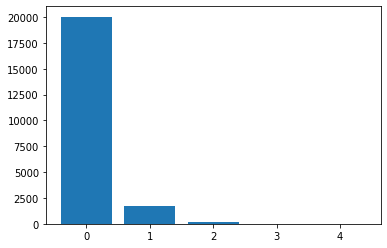

In [4]:
total_goals = np.unique(y_train, return_counts=True)
print("Goals:",total_goals[0])
print("Counts:",total_goals[1])
plt.bar(total_goals[0],total_goals[1])

# Fitting the data to a Multiple Linear Regression Model

In [5]:
# Fitting the multiple linear regresion to the training set
mlr_obj = LinearRegression()
mlr_obj.fit(X_train, y_train)


num_culmn_raw  = X_train[0,:]

print("The weight parameters are:")

#sort and print the weight parameters for each column
copy_of_coef=list(mlr_obj.coef_[0])
list_of_coeff=list(mlr_obj.coef_[0])
copy_of_coef.sort(reverse=True)

for idx, coeff in enumerate(copy_of_coef):
    index=list_of_coeff.index(copy_of_coef[idx])
    print("({}) {}: {}".format(idx, dataset_test.columns[index], copy_of_coef[idx] ))

mlr_y_pred = mlr_obj.predict(X_test)


The weight parameters are:
(0) red_cards: 0.24067770904985256
(1) own_goals: 0.21545584840597373
(2) penalties_missed: 0.12746597965456255
(3) errors_leading_to_goal: 0.12154078986611888
(4) penalties_conceded: 0.11424615553712827
(5) winning_goals: 0.1102624273136205
(6) yellow_cards: 0.0743993830886241
(7) errors_leading_to_goal_attempt: 0.0503369573208094
(8) target_missed: 0.0479261297206929
(9) ict_index: 0.046508927787989825
(10) fouls: 0.027855943135959883
(11) total_points: 0.02465191329878164
(12) offside: 0.022304813179787886
(13) tackled: 0.016079250881033232
(14) big_chances_missed: 0.013084007188018807
(15) bps: 0.011472265954534341
(16) influence: 0.011167343412671503
(17) team_a_score: 0.0065332958263155496
(18) team_h_score: 0.005410787004883118
(19) goals_conceded: 0.00426219418815026
(20) attempted_passes: 0.0009473674542686744
(21) round: 0.0006710033821079447
(22) fixture: -8.357720909269069e-05
(23) opponent_team: -0.00020343012708544213
(24) minutes: -0.0010672428

# Calculate the Mean Squared Error for the model

In [6]:
mlr_mse=metrics.mean_squared_error(y_test, mlr_y_pred)
print("Mean Squared Error for MLR:", mlr_mse)

Mean Squared Error for MLR: 0.007790253809881702


# Using backwards elimination to trim the data

In [7]:
def backwardElimination(x, sl):
    
    numVars = len(x[0])
    for i in range(0, numVars):
        
        obj_OLS = sm.OLS(endog = y, exog = x).fit()
        maxVar = max(obj_OLS.pvalues).astype(float)

        if maxVar > sl:
            
            for j in range(0, numVars - i):
                
                if (obj_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    dataset_test.drop([dataset_test.columns[j]], axis=1, inplace=True)
                    print("Droped column: ",j)
                    
    obj_OLS.summary()
    return x


X = X.astype(float)
SL = 0.05
X_sig = X[:,:]
X_Modeled = backwardElimination(X_sig, SL)

# Now run the trimed data with a linear regression model

In [8]:
# Split the data
X_sig_train, X_sig_test, y_sig_train, y_sig_test = train_test_split(
    X_Modeled, y, test_size = 0.3)

mlr_bw_obj = LinearRegression()
mlr_bw_obj.fit(X_sig_train, y_sig_train)

y_sig_pred = mlr_bw_obj.predict(X_sig_test)

num_culmn_sig  = X_Modeled[0,:]

print("The weight parameters are:")

#sort and print the weight parameters for each column

copy_of_coef=list(mlr_bw_obj.coef_[0])
list_of_coeff=list(mlr_bw_obj.coef_[0])
copy_of_coef.sort(reverse=True)

for idx, coeff in enumerate(copy_of_coef):
    index=list_of_coeff.index(copy_of_coef[idx])
    print("({}) {}: {}".format(idx, dataset_test.columns[index], copy_of_coef[idx] ))
#print("Mean Squared Error for MLR and Backward Elimination:", metrics.mean_squared_error(y_sig_test, y_sig_pred))

The weight parameters are:
(0) red_cards: 0.2462940494857625
(1) own_goals: 0.21474575412097177
(2) errors_leading_to_goal: 0.12405237800929703
(3) penalties_conceded: 0.1137499767784397
(4) winning_goals: 0.10653086293453196
(5) penalties_missed: 0.10305708381486704
(6) yellow_cards: 0.07292014435041791
(7) ict_index: 0.053383877229466435
(8) target_missed: 0.04735473722437936
(9) errors_leading_to_goal_attempt: 0.0465374975954134
(10) fouls: 0.02847606978566471
(11) total_points: 0.02377560888541076
(12) offside: 0.022305929297449657
(13) tackled: 0.016125457443186074
(14) big_chances_missed: 0.014210980220363444
(15) bps: 0.011542614747574596
(16) influence: 0.010537670601249913
(17) team_a_score: 0.0068376170149381035
(18) team_h_score: 0.005405102556750121
(19) goals_conceded: 0.00349771884090215
(20) attempted_passes: 0.0011109219622344728
(21) round: 0.00040442160818166917
(22) fixture: -5.3298232573639265e-05
(23) opponent_team: -0.00010966587764841785
(24) minutes: -0.00102496

# MLR and Backward Elimination Mean Squared Error

In [9]:
mlr_be_mse=metrics.mean_squared_error(y_sig_test, y_sig_pred)
print("Mean Squared Error for MLR and Backward Elimination:", mlr_be_mse)

Mean Squared Error for MLR and Backward Elimination: 0.007946201965473609


# Examine a Decison Tree regression

In [10]:
dtr_obj = DecisionTreeRegressor()
dtr_obj.fit(X_train, y_train)

dtr_y_pred = dtr_obj.predict(X_test)

dtr_mse=metrics.mean_squared_error(y_test, dtr_y_pred)
print("Mean Squared Error for Decision Tree:", dtr_mse)

Mean Squared Error for Decision Tree: 0.0050950005307292216


# Examine a Random Forrest model

/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y 

/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Lowest testing error = 0.0022792177357038364
Associated number of trees (n_estimator) = 270


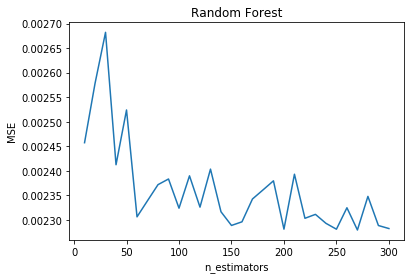

In [11]:
num_tree = []
msqe = []
x_axis=[]

for n in range (10, 301, 10):
    
    num_tree.append(n)
    
    randf_obj = RandomForestRegressor(n_estimators=n)
    randf_obj.fit(X_train, y_train)
    
    randf_y_pred = randf_obj.predict(X_test)
    
    mean_sqr_eror = metrics.mean_squared_error(y_test, 
                                               randf_y_pred)
    x_axis.append(n)
    msqe.append(mean_sqr_eror)

plt.title('Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.plot(x_axis,msqe)
print('Lowest testing error =', min(msqe))
print('Associated number of trees (n_estimator) =', 
      num_tree[msqe.index(min(msqe))])

In [12]:
print('Lowest testing error =', min(msqe))
print('Associated number of trees (n_estimator) =', 
      num_tree[msqe.index(min(msqe))])

Lowest testing error = 0.0022792177357038364
Associated number of trees (n_estimator) = 270


# PCA model examination

Lowest testing error = 0.00853666990743264
Associated number of components (n_components) = 40


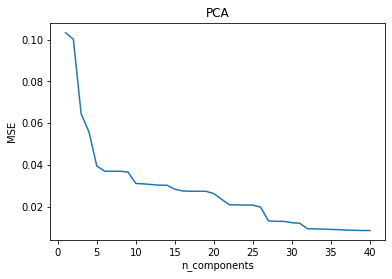

In [13]:
num_tree_pca = []
pca_error = []
x_axis=[]

for n in range(1, len(num_culmn_raw)):
    num_tree_pca.append(n)
    
    pca_obj = PCA(n_components=n)
    X_PCA_train = pca_obj.fit_transform(X_train)
    X_PCA_test = pca_obj.transform(X_test)
    components_variance = pca_obj.explained_variance_ratio_

    # Fit a linear regression to the training set
    mlr_pca_obj = LinearRegression()
    mlr_pca_obj.fit(X_PCA_train, y_train)

    y_mlr_pca_pred = mlr_pca_obj.predict(X_PCA_test)
    x_axis.append(n)

    pca_error.append(metrics.mean_squared_error(y_test, y_mlr_pca_pred))
    
 
plt.title('PCA')
plt.xlabel('n_components')
plt.ylabel('MSE')
plt.plot(x_axis,pca_error)    
print('Lowest testing error =', min(pca_error))
print('Associated number of components (n_components) =', 
      num_tree_pca[pca_error.index(min(pca_error))])

# Visualize MSE results of computed models

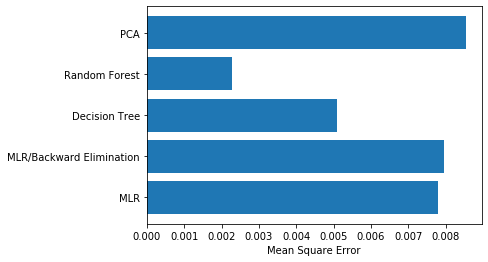

In [14]:
plot_y=[1,2,3,4,5]
plot_x=[mlr_mse,mlr_be_mse,dtr_mse,min(msqe),min(pca_error)]

plot_labels=["MLR","MLR/Backward Elimination","Decision Tree","Random Forest","PCA"]
plt.barh(plot_y, plot_x, align='center')
plt.yticks(plot_y, plot_labels)
plt.xlabel("Mean Square Error")
plt.show()

# K-Fold Tests

In [15]:
#initialize for plot
plot_x_mean=[]
plot_x_std=[]

# Multiple Linear Regression Raw
modelAccuracies = cross_val_score(estimator=mlr_obj, X=X_train, y=y_train, cv=10)
plot_x_mean.append(modelAccuracies.mean())
plot_x_std.append(modelAccuracies.std())
print("MLR Mean:", modelAccuracies.mean())
print("MLR Standard Deviation:", modelAccuracies.std())

print()

# Multilinear Regression with Backward Elimination
modelAccuracies = cross_val_score(estimator=mlr_bw_obj, X=X_train, y=y_train, cv=10)
plot_x_mean.append(modelAccuracies.mean())
plot_x_std.append(modelAccuracies.std())
print("MLR/Backward Elimination Mean:", modelAccuracies.mean())
print("MLR/Backward Elimination Deviation:", modelAccuracies.std())

print()

# Decision Tree Model
modelAccuracies = cross_val_score(estimator=dtr_obj, X=X_train, y=y_train, cv=10)
plot_x_mean.append(modelAccuracies.mean())
plot_x_std.append(modelAccuracies.std())
print("Decission Tree Mean:", modelAccuracies.mean())
print("Decission Tree Deviation:", modelAccuracies.std())

print()

# Random Forest Model
randf_obj = RandomForestRegressor(n_estimators=num_tree[msqe.index(min(msqe))])
modelAccuracies = cross_val_score(estimator=randf_obj, X=X_train, y=y_train, cv=10)
plot_x_mean.append(modelAccuracies.mean())
plot_x_std.append(modelAccuracies.std())
print("Random Forest Mean:", modelAccuracies.mean())
print("Random Forest Standard Deviation:", modelAccuracies.std())

print()

# PCA Model
modelAccuracies = cross_val_score(estimator=mlr_pca_obj, X=X_train, y=y_train, cv=5)
plot_x_mean.append(modelAccuracies.mean())
plot_x_std.append(modelAccuracies.std())
print("MLR/PCA Mean:", modelAccuracies.mean())
print("MLR/PCA Standard Deviation:", modelAccuracies.std())

MLR Mean: 0.9289505739138916
MLR Standard Deviation: 0.006570637340117199

MLR/Backward Elimination Mean: 0.9289505739138916
MLR/Backward Elimination Deviation: 0.006570637340117199

Decission Tree Mean: 0.9502210502924007
Decission Tree Deviation: 0.008961278421391826



/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/sshrest/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

Random Forest Mean: 0.974910712792347
Random Forest Standard Deviation: 0.0063899459183493525

MLR/PCA Mean: 0.9291971524931553
MLR/PCA Standard Deviation: 0.004336414184795933


# Plot model accuracies Means from K folds test

[0.007790253809881702, 0.007946201965473609, 0.0050950005307292216, 0.0022792177357038364, 0.00853666990743264]


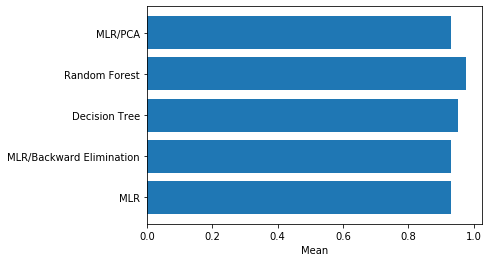

In [16]:
plot_y=[1,2,3,4,5]
print(plot_x)
plot_labels=["MLR","MLR/Backward Elimination","Decision Tree","Random Forest","MLR/PCA"]
plt.barh(plot_y, plot_x_mean, align='center')
plt.yticks(plot_y, plot_labels)
plt.xlabel("Mean")
plt.show()

# Plot model accuracies Standard Deviation from K folds test

[0.007790253809881702, 0.007946201965473609, 0.0050950005307292216, 0.0022792177357038364, 0.00853666990743264]


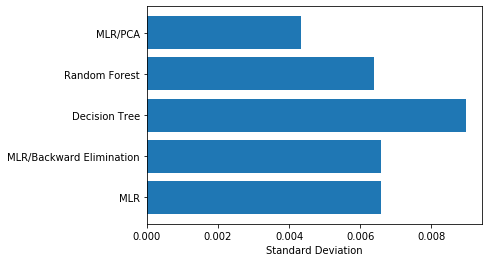

In [17]:
plot_y=[1,2,3,4,5]
print(plot_x)
plot_labels=["MLR","MLR/Backward Elimination","Decision Tree","Random Forest","MLR/PCA"]
plt.barh(plot_y, plot_x_std, align='center')
plt.yticks(plot_y, plot_labels)
plt.xlabel("Standard Deviation")
plt.show()